# 基于深度学习的个性化推荐系统

The source code from this tutorial is at [here](https://github.com/PaddlePaddle/book/tree/develop/05.recommender_system).  For instructions to run it, please refer to [this guide](https://github.com/PaddlePaddle/book/blob/develop/README.md#running-the-book).


## Background

The recommender system is a component of e-commerce, online videos, and online reading services.  There are several different approaches for recommender systems to learn from user behavior and product properties and to understand users' interests.

- User behavior-based approach.  A well-known method of this approach is collaborative filtering, which assumes that if two users made similar purchases, they share common interests and would likely go on making the same decision. Some variants of collaborative filtering are user-based[[3](#references)], item-based [[4](#references)], social network based[[5](#references)], and model-based.

- Content-based approach[[1](#references)].  This approach represents product properties and user interests as feature vectors of the same space so that it could measure how much a user is interested in a product by the distance between two feature vectors.

- Hybrid approach[[2](#references)]: This one combines above two to help with each other about the data sparsity problem[[6](#references)].

This tutorial explains a deep learning based hybrid approach and its implement in PaddlePaddle.  We are going to train a model using a dataset that includes user information, movie information, and ratings.  Once we train the model, we will be able to get a predicted rating given a pair of user and movie IDs.


## Model Overview

To know more about deep learning based recommendation, let us start from going over the Youtube recommender system[[7](#references)] before introducing our hybrid model.


### YouTube's Deep Learning Recommendation Model

YouTube is a video-sharing Web site with one of the largest user base in the world.  Its recommender system serves more than a billion users.  This system is composed of two major parts: candidate generation and ranking.  The former selects few hundreds of candidates from millions of videos, and the latter ranks and outputs the top 10.

![](http://paddlepaddle.org/docs/develop/book/05.recommender_system/image/YouTube_Overview.en.png)

#### Candidate Generation Network

YouTube models candidate generation as a multi-class classification problem with a huge number of classes equal to the number of videos.  The architecture of the model is as follows:

![](http://paddlepaddle.org/docs/develop/book/05.recommender_system/image/Deep_candidate_generation_model_architecture.en.png)

The first stage of this model maps watching history and search queries into fixed-length representative features.  Then, an MLP (multi-layer Perceptron, as described in the [Recognize Digits](https://github.com/PaddlePaddle/book/blob/develop/recognize_digits/README.md) tutorial) takes the concatenation of all representative vectors.  The output of the MLP represents the user' *intrinsic interests*.  At training time, it is used together with a softmax output layer for minimizing the classification error.   At serving time, it is used to compute the relevance of the user with all movies.

For a user $U$, the predicted watching probability of video $i$ is

$$P(\omega=i|u)=\frac{e^{v_{i}u}}{\sum_{j \in V}e^{v_{j}u}}$$

where $u$ is the representative vector of user $U$, $V$ is the corpus of all videos, $v_i$ is the representative vector of the $i$-th video. $u$ and $v_i$ are vectors of the same length, so we can compute their dot product using a fully connected layer.

This model could have a performance issue as the softmax output covers millions of classification labels.  To optimize performance, at the training time, the authors down-sample negative samples, so the actual number of classes is reduced to thousands.  At serving time, the authors ignore the normalization of the softmax outputs, because the results are just for ranking.

#### Ranking Network

The architecture of the ranking network is similar to that of the candidate generation network.  Similar to ranking models widely used in online advertising, it uses rich features like video ID, last watching time, etc.  The output layer of the ranking network is a weighted logistic regression, which rates all candidate videos.

### Hybrid Model

In the section, let us introduce our movie recommendation system. Especially, we feed moives titles into a text convolution network to get a fixed-length representative feature vector. Accordingly we will introduce the convolutional neural network for texts and the hybrid recommendation model respectively.

#### Convolutional Neural Networks for Texts (CNN)

**Convolutional Neural Networks** are frequently applied to data with grid-like topology such as two-dimensional images and one-dimensional texts. A CNN can extract multiple local features, combine them, and produce high-level abstractions, which correspond to semantic understanding. Empirically, CNN is shown to be efficient for image and text modeling.

CNN mainly contains convolution and pooling operation, with versatile combinations in various applications. Here, we briefly describe a CNN as shown in Figure 3.


![](http://paddlepaddle.org/docs/develop/book/05.recommender_system/image/text_cnn_en.png)

Let $n$ be the length of the sentence to process, and the $i$-th word has embedding as $x_i\in\mathbb{R}^k$，where $k$ is the embedding dimensionality.

First, we concatenate the words by piecing together every $h$ words, each as a window of length $h$. This window is denoted as $x_{i:i+h-1}$, consisting of $x_{i},x_{i+1},\ldots,x_{i+h-1}$, where $x_i$ is the first word in the window and $i$ takes value ranging from $1$ to $n-h+1$: $x_{i:i+h-1}\in\mathbb{R}^{hk}$.

Next, we apply the convolution operation: we apply the kernel $w\in\mathbb{R}^{hk}$ in each window, extracting features $c_i=f(w\cdot x_{i:i+h-1}+b)$, where $b\in\mathbb{R}$ is the bias and $f$ is a non-linear activation function such as $sigmoid$. Convolving by the kernel at every window ${x_{1:h},x_{2:h+1},\ldots,x_{n-h+1:n}}$ produces a feature map in the following form:

$$c=[c_1,c_2,\ldots,c_{n-h+1}], c \in \mathbb{R}^{n-h+1}$$

Next, we apply *max pooling* over time to represent the whole sentence $\hat c$, which is the maximum element across the feature map:

$$\hat c=max(c)$$

#### Model Structure Of The Hybrid Model

In our network, the input includes features of users and movies.  The user feature includes four properties: user ID, gender, occupation, and age.  Movie features include their IDs, genres, and titles.

We use fully-connected layers to map user features into representative feature vectors and concatenate them.  The process of movie features is similar, except that for movie titles -- we feed titles into a text convolution network as described in the above section to get a fixed-length representative feature vector.

Given the feature vectors of users and movies, we compute the relevance using cosine similarity.  We minimize the squared error at training time.

![](http://paddlepaddle.org/docs/develop/book/05.recommender_system/image/rec_regression_network_en.png)

## Dataset

We use the [MovieLens ml-1m](http://files.grouplens.org/datasets/movielens/ml-1m.zip) to train our model.  This dataset includes 10,000 ratings of 4,000 movies from 6,000 users to 4,000 movies.  Each rate is in the range of 1~5.  Thanks to GroupLens Research for collecting, processing and publishing the dataset.

`paddle.v2.datasets` package encapsulates multiple public datasets, including `cifar`, `imdb`, `mnist`, `moivelens` and `wmt14`, etc. There's no need for us to manually download and preprocess `MovieLens` dataset.

The raw `MoiveLens` contains movie ratings, relevant features from both movies and users.
For instance, one movie's feature could be:

```python
import paddle.v2 as paddle
movie_info = paddle.dataset.movielens.movie_info()
print movie_info.values()[0]
```

```text
<MovieInfo id(1), title(Toy Story), categories(['Animation', "Children's", 'Comedy'])>
```

One user's feature could be:

```python
user_info = paddle.dataset.movielens.user_info()
print user_info.values()[0]
```

```text
<UserInfo id(1), gender(F), age(1), job(10)>
```

In this dateset, the distribution of age is shown as follows:

```text
1: "Under 18"
18: "18-24"
25: "25-34"
35: "35-44"
45: "45-49"
50: "50-55"
56: "56+"
```

User's occupation is selected from the following options:

```text
0: "other" or not specified
1: "academic/educator"
2: "artist"
3: "clerical/admin"
4: "college/grad student"
5: "customer service"
6: "doctor/health care"
7: "executive/managerial"
8: "farmer"
9: "homemaker"
10: "K-12 student"
11: "lawyer"
12: "programmer"
13: "retired"
14: "sales/marketing"
15: "scientist"
16: "self-employed"
17: "technician/engineer"
18: "tradesman/craftsman"
19: "unemployed"
20: "writer"
```

Each record consists of three main components: user features, movie features and movie ratings.
Likewise, as a simple example, consider the following:

```python
train_set_creator = paddle.dataset.movielens.train()
train_sample = next(train_set_creator())
uid = train_sample[0]
mov_id = train_sample[len(user_info[uid].value())]
print "User %s rates Movie %s with Score %s"%(user_info[uid], movie_info[mov_id], train_sample[-1])
```

```text
User <UserInfo id(1), gender(F), age(1), job(10)> rates Movie <MovieInfo id(1193), title(One Flew Over the Cuckoo's Nest), categories(['Drama'])> with Score [5.0]
```

The output shows that user 1 gave movie `1193` a rating of 5.

After issuing a command `python train.py`, training will start immediately. The details will be unpacked by the following sessions to see how it works.

## Model Architecture

### Initialize PaddlePaddle

First, we must import and initialize PaddlePaddle (enable/disable GPU, set the number of trainers, etc).

```python
import paddle.v2 as paddle
paddle.init(use_gpu=False)
```

### Model Configuration

```python
uid = paddle.layer.data(
    name='user_id',
    type=paddle.data_type.integer_value(
        paddle.dataset.movielens.max_user_id() + 1))
usr_emb = paddle.layer.embedding(input=uid, size=32)
usr_fc = paddle.layer.fc(input=usr_emb, size=32)

usr_gender_id = paddle.layer.data(
    name='gender_id', type=paddle.data_type.integer_value(2))
usr_gender_emb = paddle.layer.embedding(input=usr_gender_id, size=16)
usr_gender_fc = paddle.layer.fc(input=usr_gender_emb, size=16)

usr_age_id = paddle.layer.data(
    name='age_id',
    type=paddle.data_type.integer_value(
        len(paddle.dataset.movielens.age_table)))
usr_age_emb = paddle.layer.embedding(input=usr_age_id, size=16)
usr_age_fc = paddle.layer.fc(input=usr_age_emb, size=16)

usr_job_id = paddle.layer.data(
    name='job_id',
    type=paddle.data_type.integer_value(
        paddle.dataset.movielens.max_job_id() + 1))
usr_job_emb = paddle.layer.embedding(input=usr_job_id, size=16)
usr_job_fc = paddle.layer.fc(input=usr_job_emb, size=16)
```

As shown in the above code, the input is four dimension integers for each user, that is,  `user_id`,`gender_id`, `age_id` and `job_id`. In order to deal with these features conveniently, we use the language model in NLP to transform these discrete values into embedding vaules `usr_emb`, `usr_gender_emb`, `usr_age_emb` and `usr_job_emb`.

```python
usr_combined_features = paddle.layer.fc(
        input=[usr_fc, usr_gender_fc, usr_age_fc, usr_job_fc],
        size=200,
        act=paddle.activation.Tanh())
```

Then, employing user features as input, directly connecting to a fully-connected layer, which is used to reduce dimension to 200.

Furthermore, we do a similar transformation for each movie feature. The model configuration is:

```python
mov_id = paddle.layer.data(
    name='movie_id',
    type=paddle.data_type.integer_value(
        paddle.dataset.movielens.max_movie_id() + 1))
mov_emb = paddle.layer.embedding(input=mov_id, size=32)
mov_fc = paddle.layer.fc(input=mov_emb, size=32)

mov_categories = paddle.layer.data(
    name='category_id',
    type=paddle.data_type.sparse_binary_vector(
        len(paddle.dataset.movielens.movie_categories())))
mov_categories_hidden = paddle.layer.fc(input=mov_categories, size=32)

movie_title_dict = paddle.dataset.movielens.get_movie_title_dict()
mov_title_id = paddle.layer.data(
    name='movie_title',
    type=paddle.data_type.integer_value_sequence(len(movie_title_dict)))
mov_title_emb = paddle.layer.embedding(input=mov_title_id, size=32)
mov_title_conv = paddle.networks.sequence_conv_pool(
    input=mov_title_emb, hidden_size=32, context_len=3)

mov_combined_features = paddle.layer.fc(
    input=[mov_fc, mov_categories_hidden, mov_title_conv],
    size=200,
    act=paddle.activation.Tanh())
```

Movie title, a sequence of words represented by an integer word index sequence, will be feed into a `sequence_conv_pool` layer, which will apply convolution and pooling on time dimension. Because pooling is done on time dimension, the output will be a fixed-length vector regardless the length of the input sequence.

Finally, we can use cosine similarity to calculate the similarity between user characteristics and movie features.

```python
inference = paddle.layer.cos_sim(a=usr_combined_features, b=mov_combined_features, size=1, scale=5)
cost = paddle.layer.square_error_cost(
        input=inference,
        label=paddle.layer.data(
        name='score', type=paddle.data_type.dense_vector(1)))
```

## Model Training

### Define Parameters

First, we define the model parameters according to the previous model configuration `cost`.

```python
# Create parameters
parameters = paddle.parameters.create(cost)
```

### Create Trainer

Before jumping into creating a training module, algorithm setting is also necessary. Here we specified Adam optimization algorithm via `paddle.optimizer`.

```python
trainer = paddle.trainer.SGD(cost=cost, parameters=parameters,
                             update_equation=paddle.optimizer.Adam(learning_rate=1e-4))
```

```text
[INFO 2017-03-06 17:12:13,378 networks.py:1472] The input order is [user_id, gender_id, age_id, job_id, movie_id, category_id, movie_title, score]
[INFO 2017-03-06 17:12:13,379 networks.py:1478] The output order is [__square_error_cost_0__]
```

### Training

`paddle.dataset.movielens.train` will yield records during each pass, after shuffling, a batch input is generated for training.

```python
reader=paddle.batch(
    paddle.reader.shuffle(
        paddle.dataset.movielens.train(), buf_size=8192),
        batch_size=256)
```

`feeding` is devoted to specifying the correspondence between each yield record and `paddle.layer.data`. For instance, the first column of data generated by `movielens.train` corresponds to `user_id` feature.

```python
feeding = {
    'user_id': 0,
    'gender_id': 1,
    'age_id': 2,
    'job_id': 3,
    'movie_id': 4,
    'category_id': 5,
    'movie_title': 6,
    'score': 7
}
```

Callback function `event_handler` and  `event_handler_plot` will be called during training when a pre-defined event happens.

```python
def event_handler(event):
    if isinstance(event, paddle.event.EndIteration):
        if event.batch_id % 100 == 0:
            print "Pass %d Batch %d Cost %.2f" % (
                event.pass_id, event.batch_id, event.cost)
```

```python
from paddle.v2.plot import Ploter

train_title = "Train cost"
test_title = "Test cost"
cost_ploter = Ploter(train_title, test_title)

step = 0

def event_handler_plot(event):
    global step
    if isinstance(event, paddle.event.EndIteration):
        if step % 10 == 0:  # every 10 batches, record a train cost
            cost_ploter.append(train_title, step, event.cost)

        if step % 1000 == 0: # every 1000 batches, record a test cost
            result = trainer.test(
                reader=paddle.batch(
                    paddle.dataset.movielens.test(), batch_size=256),
                feeding=feeding)
            cost_ploter.append(test_title, step, result.cost)

        if step % 100 == 0: # every 100 batches, update cost plot
            cost_ploter.plot()

        step += 1
```

Finally, we can invoke `trainer.train` to start training:

```python
trainer.train(
    reader=reader,
    event_handler=event_handler_plot,
    feeding=feeding,
    num_passes=2)
```

## Conclusion

This tutorial goes over traditional approaches in recommender system and a deep learning based approach.  We also show that how to train and use the model with PaddlePaddle.  Deep learning has been well used in computer vision and NLP, we look forward to its new successes in recommender systems.

## References

1. [Peter Brusilovsky](https://en.wikipedia.org/wiki/Peter_Brusilovsky) (2007). *The Adaptive Web*. p. 325.
2. Robin Burke , [Hybrid Web Recommender Systems](http://www.dcs.warwick.ac.uk/~acristea/courses/CS411/2010/Book%20-%20The%20Adaptive%20Web/HybridWebRecommenderSystems.pdf), pp. 377-408, The Adaptive Web, Peter Brusilovsky, Alfred Kobsa, Wolfgang Nejdl (Ed.), Lecture Notes in Computer Science, Springer-Verlag, Berlin, Germany, Lecture Notes in Computer Science, Vol. 4321, May 2007, 978-3-540-72078-2.
3. P. Resnick, N. Iacovou, etc. “[GroupLens: An Open Architecture for Collaborative Filtering of Netnews](http://ccs.mit.edu/papers/CCSWP165.html)”, Proceedings of ACM Conference on Computer Supported Cooperative Work, CSCW 1994. pp.175-186.
4. Sarwar, Badrul, et al. "[Item-based collaborative filtering recommendation algorithms.](http://files.grouplens.org/papers/www10_sarwar.pdf)" *Proceedings of the 10th International Conference on World Wide Web*. ACM, 2001.
5. Kautz, Henry, Bart Selman, and Mehul Shah. "[Referral Web: Combining Social networks and collaborative filtering.](http://www.cs.cornell.edu/selman/papers/pdf/97.cacm.refweb.pdf)" Communications of the ACM 40.3 (1997): 63-65. APA
6. Yuan, Jianbo, et al. ["Solving Cold-Start Problem in Large-scale Recommendation Engines: A Deep Learning Approach."](https://arxiv.org/pdf/1611.05480v1.pdf) *arXiv preprint arXiv:1611.05480* (2016).
7. Covington P, Adams J, Sargin E. [Deep neural networks for youtube recommendations](https://static.googleusercontent.com/media/research.google.com/zh-CN//pubs/archive/45530.pdf)[C]//Proceedings of the 10th ACM Conference on Recommender Systems. ACM, 2016: 191-198.

<br/>
This tutorial is contributed by <a xmlns:cc="http://creativecommons.org/ns#" href="http://book.paddlepaddle.org" property="cc:attributionName" rel="cc:attributionURL">PaddlePaddle</a>, and licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

## 运行代码

在当前目录下打开命令行窗口，输入：python paddle_dnn.py 

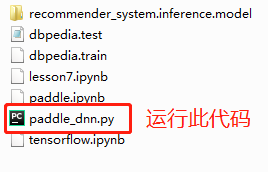

运行结果如图：

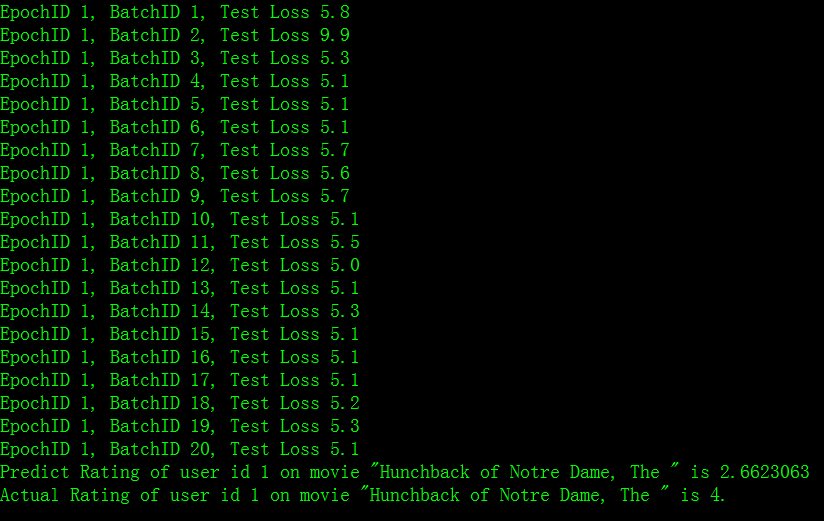